In [28]:
import gymnasium as gym
from agilerl.components.replay_buffer import ReplayBuffer
from agilerl.algorithms.ddpg import DDPG
from pettingzoo.sisl import multiwalker_v9
import numpy as np

rewards_iterations = []

for i in range(10) :
# Create environment and Experience Replay Buffer
# env = multiwalker_v9.parallel_env(render_mode='human')
    env = multiwalker_v9.parallel_env()
    env.reset()
    try:
        state_dim = [env.observation_space(agent).shape[0] for agent in env.agents]
        one_hot = False
        
    except Exception:
        state_dim = [env.observation_space(agent).n for agent in env.agents]
        one_hot = True
    # Requires one-hot encoding
    try:
        action_dim = [env.action_space(agent).shape[0] for agent in env.agents]
    except Exception:
        action_dim = [env.action_space(agent).n for agent in env.agents]

    field_names = ["state", "action", "reward", "next_state", "done"]
    memories = {a:ReplayBuffer(memory_size=300, field_names=field_names, action_dim=action_dim[0]) for a in env.agents}   # Create Experience Replay Buffer
    agents = {a:DDPG(state_dim=state_dim, action_dim=action_dim[0], one_hot=one_hot) for a in env.agents}   # Create DDPG agents
    # for a, agent in agents.items():
    #     path = "./models/ONE_DDPG/DDPG5_trained_agent.pt"
    #     DDPG.loadCheckpoint(agent,path=path)


    reward_evolution = []
    rewards = []

    for i in range(200):
        print(i, "th iteration \nrewards : ", np.sum(rewards))
        reward_evolution.append(np.sum(rewards))
        
        state = env.reset()[0]  # Reset environment at start of episode
        # state = state['walker_0']
        done = [False]
        rewards = []

        # print(state)

        while done[0] == False:
            actions = {a:agent.getAction(state[a])[0] for a, agent in agents.items()}    # Get next action from agent
            # print(actions)
            # actions = {agent: actions for agent in env.agents}
            next_state, reward, done, _, _ = env.step(actions)   # Act in environment
            if 'walker_0' in next_state.keys():
                # next_state = next_state['walker_0']
                done = [True] if done['walker_0'] or done['walker_1'] or done['walker_2'] else [False]
            else :
                next_state = {a:np.empty((31,)) for a in env.agents}
                done = [True]
            # reward = reward['walker_0']
            rewards.append(sum(reward.values())/len(reward))
            for a in env.agents:
                memories[a].save2memory(state[a], actions[a], reward[a], next_state[a], done)
                # Learn according to learning frequency
            state = next_state
            for a in env.agents:
                if len(memories[a]) >= agents[a].batch_size:
                    experiences = memories[a].sample(agents[a].batch_size) # Sample replay buffer
                    # print("exp", type(experiences), "\n\n" )
                    agents[a].learn(experiences)    # Learn according to agent's RL algorithm
    env.close()
    rewards_iterations.append(reward_evolution)

0 th iteration 
rewards :  0.0
1 th iteration 
rewards :  -110.29207523167133
2 th iteration 
rewards :  -110.50843586524327
3 th iteration 
rewards :  -103.67026827608547
4 th iteration 
rewards :  -105.14895572761694
5 th iteration 
rewards :  -104.12528854732712
6 th iteration 
rewards :  -104.8299750785033
7 th iteration 
rewards :  -106.76289243002734
8 th iteration 
rewards :  -107.02283596992493
9 th iteration 
rewards :  -114.26783922314644
10 th iteration 
rewards :  -110.03881226480009
11 th iteration 
rewards :  -107.54753291234374
12 th iteration 
rewards :  -107.68577895810208
13 th iteration 
rewards :  -106.19642796864112
14 th iteration 
rewards :  -106.04308541119102
15 th iteration 
rewards :  -106.59076523035765
16 th iteration 
rewards :  -109.94088085740805
17 th iteration 
rewards :  -111.09527564048767
18 th iteration 
rewards :  -106.45414442320666
19 th iteration 
rewards :  -107.84449370205402
20 th iteration 
rewards :  -105.27687775095303
21 th iteration 
re

In [24]:
import os
# Save the trained algorithm
path = "./models/MULTI_DDPG"
os.makedirs(path, exist_ok=True)
for a,agent in agents.items():
    filename = a+"_DDPG_trained_agent6_reward100.pt"
    save_path = os.path.join(path, filename)
    agent.saveCheckpoint(save_path) 


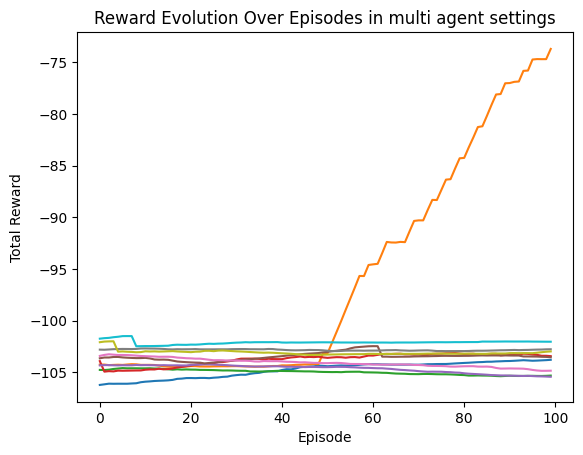

In [30]:
import matplotlib.pyplot as plt
# for i in rewards_iterations:
#     plt.plot(i[1:])
# plt.plot(reward_evolution[1:])
plt.xlabel('Episode')
plt.ylabel('Total Reward')
for i in rewards_iterations:
    reward_evolution_smoothed = np.convolve(i[1:], np.ones(100)/100, mode='valid')
    plt.plot(reward_evolution_smoothed)
    
plt.title('Reward Evolution Over Episodes in multi agent settings')
plt.show()

In [26]:
from PIL import Image, ImageDraw
import imageio


# Define function to label the frame with episode number
def _label_with_episode_number(frame, episode_num):
    im = Image.fromarray(frame)
    drawer = ImageDraw.Draw(im)
    text_color = (255, 255, 255) if np.mean(frame) < 128 else (0, 0, 0)
    drawer.text((im.size[0] / 20, im.size[1] / 18), f"Episode: {episode_num+1}", fill=text_color)
    return im

env = multiwalker_v9.parallel_env(render_mode='rgb_array')
frames = []

env.reset()

agents = {a:DDPG(state_dim=state_dim, action_dim=action_dim[0], one_hot=one_hot) for a in env.agents}   # Create DDPG agents
# Load the trained MADDPG model
path = "./models/MULTI_DDPG/"
filename = "_DDPG_trained_agent6_reward100.pt"
for a, agent in agents.items():
    DDPG.loadCheckpoint(agent,path=path+a+filename)
rewards = []

for i in range(10):
    print(i, "th iteration \nrewards : ", np.sum(rewards))
    reward_evolution.append(np.sum(rewards))
    
    state = env.reset()[0]  # Reset environment at start of episode
    done = [False]
    rewards = []

    while done[0] == False:
        actions = {a:agent.getAction(state[a])[0] for a, agent in agents.items()}    # Get next action from agent
        
        next_state, reward, done, _, _ = env.step(actions)   # Act in environment
        if 'walker_0' in next_state.keys():
            done = [True] if done['walker_0'] or done['walker_1'] or done['walker_2'] else [False]
        else :
            next_state = {a:np.empty((31,)) for a in env.agents}
            done = [True]
        rewards.append(sum(reward.values())/len(reward))
        # Render and save the frame for video creation
        frame = env.render()  # Now renders an RGB array
        if frame is not None:
            frames.append(_label_with_episode_number(frame, episode_num=i))
        state = next_state

env.close()

# Save frames as an MP4 video
video_path = "./videos/"
os.makedirs(video_path, exist_ok=True)
with imageio.get_writer(os.path.join(video_path, "multiwalker_duplicate_multi6_reward100.mp4"), fps=30) as writer:
    for frame in frames:
        writer.append_data(np.array(frame))

0 th iteration 
rewards :  0.0
1 th iteration 
rewards :  -104.46294536689918
2 th iteration 
rewards :  -104.35135202606519
3 th iteration 
rewards :  -104.51922494079918
4 th iteration 
rewards :  -104.63117904961109
5 th iteration 
rewards :  -104.29315664370854
6 th iteration 
rewards :  -104.51936312392355
7 th iteration 
rewards :  -104.47055607040724
8 th iteration 
rewards :  -104.42772032599898
9 th iteration 
rewards :  -104.02465758721034


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x650e1c0] Warning: data is not aligned! This can lead to a speed loss
